# References

Ranalli
- https://ui.adsabs.harvard.edu/abs/2018A%26A...614A..30R/abstract

Wright & Howard
- https://ui.adsabs.harvard.edu/abs/2009ApJS..182..205W/abstract
- Table 1 of many variables I use 
- Section 3: Applications to Astrometry goes more in depth to the astrometric equation than Ranalli does 

Perryman 
- Exoplanet Handbook (Textbook, Section 3: Astrometry)
- Available on the McMaster Online library 
- Also useful for astrometric equations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, sin
import rebound

from functions import calculate_thiele_innes

# Initial values 

| Parameter        | Name | Bounds |
| ---              | --- | --- |
| $\Delta\alpha_0$ | Difference between true and nominal position at $t_0$ | Normal(0,0.04) [mas] |
| $\Delta\delta_0$ | Difference between true and nominal position at $t_0$ | Normal(0,0.04) [mas] |
| $\mu_\alpha$     | Proper motion in RA direction                         | Constant value* [rad] |
| $\mu_\delta$     | Proper motion in Dec direction                        | Constant value* [rad] |
| $\varpi$         | Parallax                                              | Constant value* [rad] |
| $m_{planet}$     | Planet mass                                           | Actual value [$M_\odot$] |
| $P_{orb}$        | Orbital period                                        | Jupiter found using Uniform(0,5.5) and Saturn is scaled factor of that [years] |
| $t_{peri}$       | Time of periastron passage                            | Uniform(0, $P_{orb}$) [years] |
| $e$              | Eccentricity                                          | Both 0.1*    |
| $\Omega$         | Angle of ascending node                               | Actual value [rad]|
| $\omega$         | Argument of periastron                                | Actual value [rad]|
| $\cos i$         | Cosine of inclination                                 | Average of actual inclinations |

- *These values were randomly chosen for simplicity. Goal when making this was just so get it to work, not necessarially make it accurate to real data. 
- Actual values were taken from NASA

In [3]:
# no planet terms 

np.random.seed(8)

# no planet variables 
Delta_alpha_0 = np.random.normal(0, 1.93925472e-10)
Delta_delta_0 = np.random.normal(0, 1.93925472e-10)
mu_alpha = 2.3084641853871365e-07
mu_delta = 1.770935480191023e-07
parallax = 9.699321049402031e-08


Omega = np.random.uniform(0, 2*np.pi)
cos_i = np.random.uniform(0, 1)

# Planet 1 variables (Jupiter)



# shared planetary variables 
e = 0.1
inc = [0.022759093, 0.043388885]
cos_i = np.cos(np.mean(inc))

# Planet 1 variables (Jupiter)
omega_1 = 4.772463213
Omega_1 = 1.75503590062
m_planet_1 = 0.00095459
P_orb_1 = np.random.uniform(0, 5.5)
t_peri_1 = np.random.uniform(0, P_orb_1)

# Planet 2 variables (Saturn)
omega_2 = 5.8674129728
Omega_2 = 1.98470185703
m_planet_2 = 0.0002857
P_orb_2 = P_orb_1*29.4/11.86
t_peri_2 = np.random.uniform(0, P_orb_2)

# other variables
N = 200
times = np.linspace(0, 5.5, N)
a_earth = 1
alpha0, delta0 = 1, 0.3
rad_mas = 206264806 # this factor changes units from radians to mas

# Finding terms 

In Ranalli 

$\Delta\eta(t)=\Delta\alpha\cos\theta(t)+\Delta\delta\sin\theta(t)$,

where 

$\Delta\alpha = \Delta\alpha_0 + \Pi_\alpha\varpi+(t-t_0)\mu_\alpha +(BX(t)+GY(t))$,

and 

$\Delta\delta = \Delta\delta_0 + \Pi_\delta\varpi+(t-t_0)\mu_\delta +(AX(t)+FY(t))$

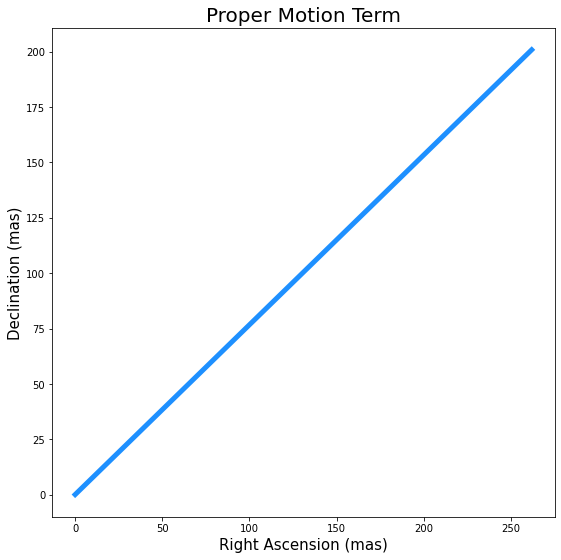

In [4]:
# finding the proper motion terms 

# we are assuming that t_0 = 0 

pm_term_ra, pm_term_dec = np.zeros((N)),np.zeros((N))

# for i in range(N):
pm_term_ra  = mu_alpha * times  + Delta_alpha_0
pm_term_dec = mu_delta * times  + Delta_delta_0

# plotting 
plt.figure(figsize=(9,9))
plt.xlabel("Right Ascension (mas)", fontsize=15)
plt.ylabel("Declination (mas)", fontsize=15)
plt.title("Proper Motion Term", fontsize=20)


plt.plot((pm_term_ra-pm_term_ra[0])*rad_mas, 
         (pm_term_dec-pm_term_dec[0])*rad_mas, 
         lw=5,
         color='dodgerblue')

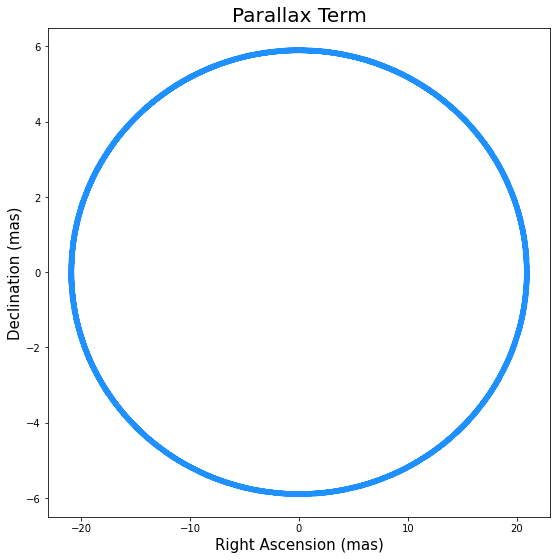

In [5]:
# finding the parallax terms

d = a_earth/parallax
sind, cosd, sina, cosa  = sin(delta0), cos(delta0), sin(alpha0), cos(alpha0)

T = times

prlx_term_ra  = (a_earth/(d*cosd))*(sina*cos(2*np.pi*T)-cosa*sin(2*np.pi*T))               
prlx_term_dec = (a_earth/d)*sind*cos(2*np.pi*T-alpha0) 

# plotting 
plt.figure(figsize=(9,9))
plt.xlabel("Right Ascension (mas)", fontsize=15)
plt.ylabel("Declination (mas)", fontsize=15)
plt.title("Parallax Term", fontsize=20)

plt.plot(prlx_term_ra*rad_mas, 
         prlx_term_dec*rad_mas,
         lw=5,
         color='dodgerblue')

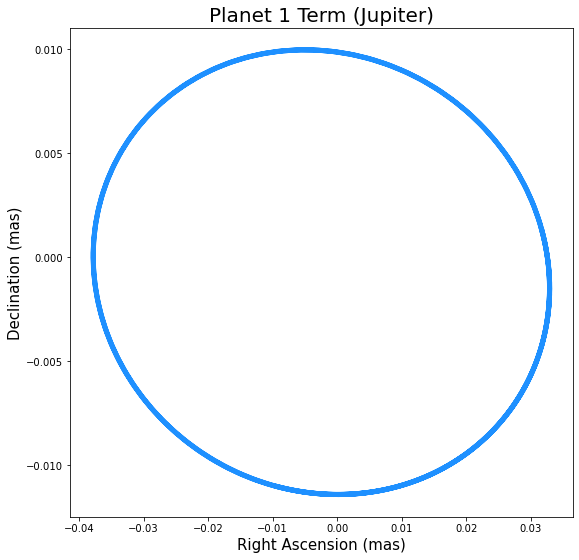

In [11]:
# finding the planetary 1 term

sind, cosd, sina, cosa  = sin(delta0), cos(delta0), sin(alpha0), cos(alpha0) # same for both


B_1, A_1, F_1, G_1, H_1, C_1, _ = calculate_thiele_innes(omega_1, Omega_1, cos_i, parallax, m_planet_1, P_orb_1)

M_1 = (2*np.pi)*(times - t_peri_1)/P_orb_1  

E_1 = np.vectorize(rebound.M_to_E)(e,M_1)

X_1 = (cos(E_1)-e)
Y_1 = np.sqrt((1-e**2))*sin(E_1)

DELTA_X_1 = A_1*X_1+F_1*Y_1            
DELTA_Y_1 = B_1*X_1+G_1*Y_1            
DELTA_Z_1 = H_1*X_1+C_1*Y_1  

plnt_term_ra_1  = (1/cosd) * (sina*DELTA_X_1-cosa*DELTA_Y_1)
plnt_term_dec_1 = (-cosd*DELTA_Z_1 + sind*(DELTA_X_1*cosa+DELTA_Y_1*sina))

# plotting 
plt.figure(figsize=(9,9))
plt.xlabel("Right Ascension (mas)", fontsize=15)
plt.ylabel("Declination (mas)", fontsize=15)
plt.title("Planet 1 Term (Jupiter)", fontsize=20)

plt.plot(plnt_term_ra_1*rad_mas, 
         plnt_term_dec_1*rad_mas, 
         lw=5,
         color='dodgerblue') 

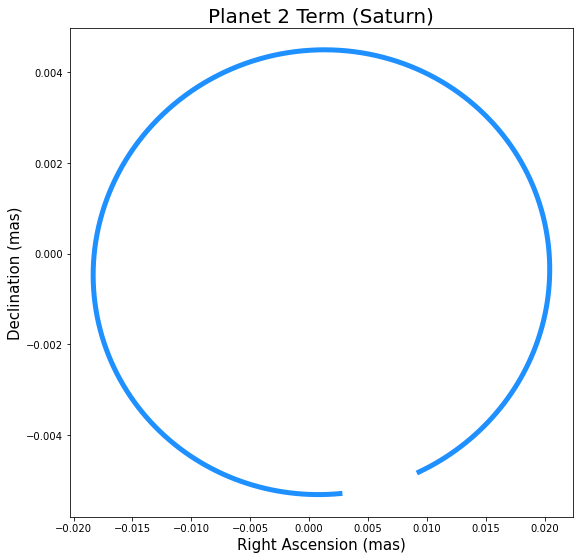

In [14]:
# finding the planetary 1 term


B_2, A_2, F_2, G_2, H_2, C_2, _ = calculate_thiele_innes(omega_2, Omega_2, cos_i, parallax, m_planet_2, P_orb_2)

M_2 = (2*np.pi)*(times - t_peri_2)/P_orb_2  

E_2 = np.vectorize(rebound.M_to_E)(e,M_2)

X_2 = (cos(E_2)-e)
Y_2 = np.sqrt((1-e**2))*sin(E_2)

DELTA_X_2 = A_2*X_2+F_2*Y_2            
DELTA_Y_2 = B_2*X_2+G_2*Y_2            
DELTA_Z_2 = H_2*X_2+C_2*Y_2  

plnt_term_ra_2  = (1/cosd) * (sina*DELTA_X_2-cosa*DELTA_Y_2)
plnt_term_dec_2 = (-cosd*DELTA_Z_2 + sind*(DELTA_X_2*cosa+DELTA_Y_2*sina))

# plotting 
plt.figure(figsize=(9,9))
plt.xlabel("Right Ascension (mas)", fontsize=15)
plt.ylabel("Declination (mas)", fontsize=15)
plt.title("Planet 2 Term (Saturn)", fontsize=20)

plt.plot(plnt_term_ra_2*rad_mas, 
         plnt_term_dec_2*rad_mas, 
         lw=5,
         color='dodgerblue') 

# Plotting 

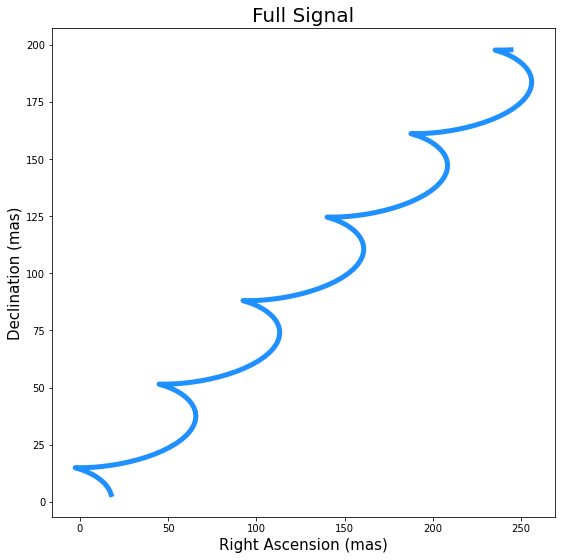

In [15]:
# Plotting the full signal 

plt.figure(figsize=(9,9))
plt.xlabel("Right Ascension (mas)", fontsize=15)
plt.ylabel("Declination (mas)", fontsize=15)
plt.title("Full Signal", fontsize=20)

signal_ra = pm_term_ra - pm_term_ra[0] + prlx_term_ra + plnt_term_ra_1 + plnt_term_ra_2
signal_dec = pm_term_dec - pm_term_dec[0] + prlx_term_dec + plnt_term_dec_1 + plnt_term_dec_2

plt.plot(signal_ra*rad_mas, 
         signal_dec*rad_mas,
         lw=5,
         color='dodgerblue') 